# Landscape Image Generation Using Generative Adversarial Networks (GANs)

In this project, we train a GAN to generate landscape images using landscape dataset available on Kaggle.



##Generative Adversarial Networks (GANs)
Generative Adversarial Networks (GANs) offer a unique approach to generative modeling, characterized by a competitive interplay between two neural networks:


*   Generator: Aims to generate realistic images.
*   Discriminator: Aims to distinguish between real and generated images.

By engaging these two models in a competitive setting, GANs can generate highly realistic images after sufficient training.

Generative Adversarial Network (GAN) takes the following approach:

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator).

Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization.



## Downloading and Exploring the Data

Using the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle.  


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/arnaud58/landscape-pictures'
od.download(dataset_url, 'Dataset_landscape')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kusum811
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures


100%|██████████| 620M/620M [00:29<00:00, 22.1MB/s]


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [ ]:
import os

DATA_DIR = './Dataset_landscape'
print(os.listdir(DATA_DIR))

['landscape-pictures']


In [ ]:
print(os.listdir(DATA_DIR+'/landscape-pictures')[:10])

['00000346_(6).jpg', '00000345_(3).jpg', '00000136_(3).jpg', '00000267_(3).jpg', '00000633_(3).jpg', '00000098_(6).jpg', '00000443_(4).jpg', '00000254_(4).jpg', '00000331_(6).jpg', '00000353_(4).jpg']


We tried different values for different variables and these are the best values we found.

Learning_Rate = 0.0005          # Tried with other values as well like 0.0001, 0.0002, 0.004

Batch_Size = 64

Image_Size = 64                  # Due to limited time and computational resources

Epochs = 300                     # Only show results here with 100 epochs

Image_Channels = 3               # We will be using colored (RGB) photos

Noise_Channels = 256

Generator_Features = 64

Discriminator_Features = 64

## Data Preparation

### Loading the Dataset:

Utilize the `ImageFolder` class from the `torchvision` library to load the dataset.

### Image Preprocessing:

*   Resizing and Cropping: Resize and center-crop the images to 64x64 pixels.
*   Normalization: Normalize the pixel values using a mean and standard deviation of 0.5 for each channel. This scales the pixel values to the range (-1, 1), which is beneficial for training the discriminator.

### Creating a Data Loader:

Construct a data loader to handle batch processing of the dataset, facilitating efficient loading during model training.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

### Visualizing the images in dataset

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

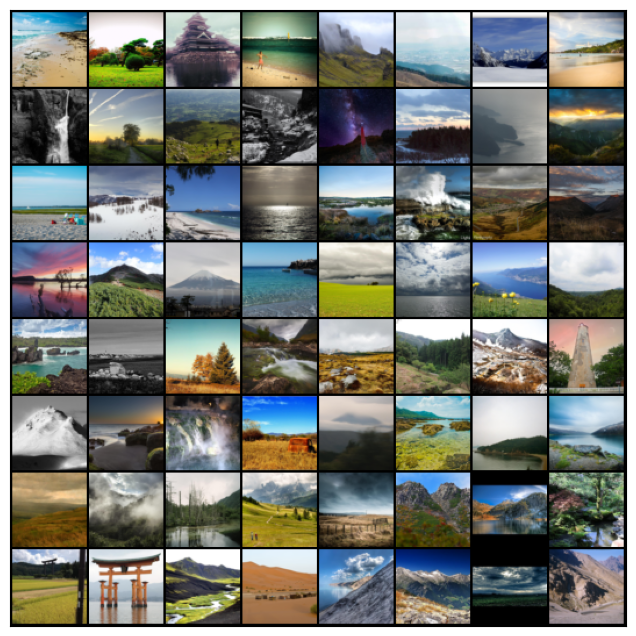

In [ ]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we will use the Leaky ReLU activation for the discriminator.

>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [ ]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*).

![](https://i.imgur.com/DRvK546.gif)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.

Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


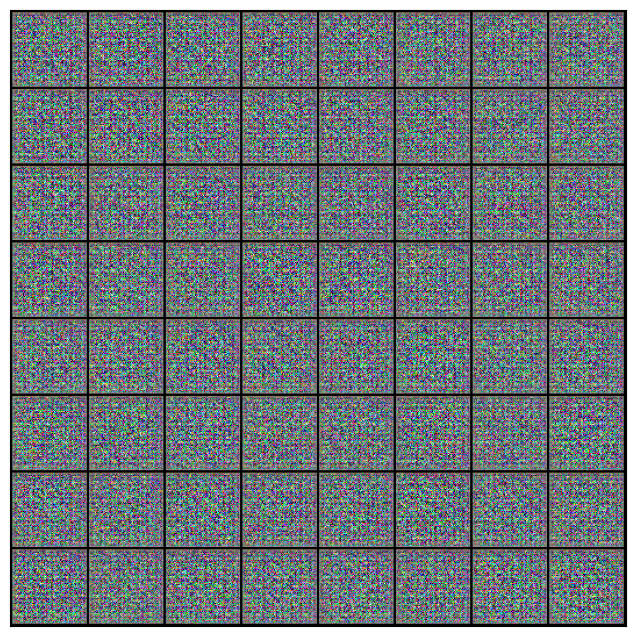

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [ ]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real Landscape pictures dataset, and 0 if it was generated using the generator network.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then, we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally, we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It is important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1, that is, real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent, that is, change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


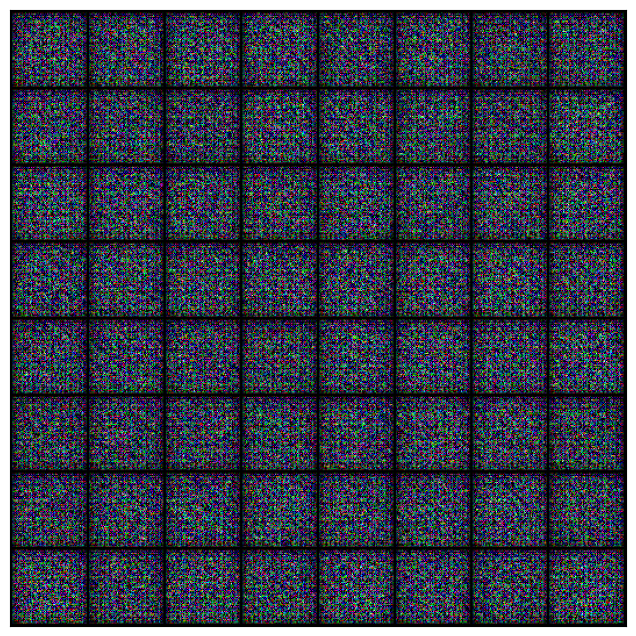

In [ ]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [ ]:
# lr = 0.0002
# epochs = 25

In [ ]:
lr = 0.0005
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.1429, loss_d: 1.6095, real_score: 0.7716, fake_score: 0.6651
Saving generated-images-0001.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 2.6882, loss_d: 0.6956, real_score: 0.6115, fake_score: 0.1267
Saving generated-images-0002.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 1.5033, loss_d: 1.1525, real_score: 0.4131, fake_score: 0.0884
Saving generated-images-0003.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 4.8799, loss_d: 1.2076, real_score: 0.9138, fake_score: 0.6342
Saving generated-images-0004.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.7861, loss_d: 0.5556, real_score: 0.7092, fake_score: 0.1239
Saving generated-images-0005.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.2154, loss_d: 1.3142, real_score: 0.9232, fake_score: 0.6573
Saving generated-images-0006.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.3789, loss_d: 0.8066, real_score: 0.9390, fake_score: 0.4900
Saving generated-images-0007.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.9226, loss_d: 0.6805, real_score: 0.6503, fake_score: 0.1851
Saving generated-images-0008.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 5.5886, loss_d: 1.2278, real_score: 0.9362, fake_score: 0.6486
Saving generated-images-0009.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 2.9458, loss_d: 0.4858, real_score: 0.8562, fake_score: 0.2562
Saving generated-images-0010.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.5293, loss_d: 0.7483, real_score: 0.6080, fake_score: 0.1694
Saving generated-images-0011.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.6331, loss_d: 0.5409, real_score: 0.6279, fake_score: 0.0177
Saving generated-images-0012.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 0.9690, loss_d: 1.2643, real_score: 0.3615, fake_score: 0.0353
Saving generated-images-0013.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.7405, loss_d: 0.6027, real_score: 0.6682, fake_score: 0.1314
Saving generated-images-0014.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 2.7395, loss_d: 1.0555, real_score: 0.4302, fake_score: 0.0244
Saving generated-images-0015.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.5977, loss_d: 0.4796, real_score: 0.7985, fake_score: 0.2039
Saving generated-images-0016.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.5717, loss_d: 0.6079, real_score: 0.6219, fake_score: 0.0656
Saving generated-images-0017.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 2.2979, loss_d: 0.7995, real_score: 0.5047, fake_score: 0.0274
Saving generated-images-0018.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.3498, loss_d: 0.7952, real_score: 0.5924, fake_score: 0.0180
Saving generated-images-0019.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 7.3461, loss_d: 1.0084, real_score: 0.9608, fake_score: 0.5636
Saving generated-images-0020.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.8474, loss_d: 0.5755, real_score: 0.8788, fake_score: 0.3174
Saving generated-images-0021.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 1.1819, loss_d: 1.0293, real_score: 0.5318, fake_score: 0.1478
Saving generated-images-0022.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.9185, loss_d: 1.5397, real_score: 0.2777, fake_score: 0.0044
Saving generated-images-0023.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.2442, loss_d: 0.4445, real_score: 0.8474, fake_score: 0.2171
Saving generated-images-0024.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.0848, loss_d: 0.3354, real_score: 0.9438, fake_score: 0.2153
Saving generated-images-0025.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.2945, loss_d: 0.3526, real_score: 0.8908, fake_score: 0.1876
Saving generated-images-0026.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.4855, loss_d: 0.5109, real_score: 0.7251, fake_score: 0.1289
Saving generated-images-0027.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.8010, loss_d: 0.4447, real_score: 0.9485, fake_score: 0.2896
Saving generated-images-0028.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 4.4904, loss_d: 0.4825, real_score: 0.8227, fake_score: 0.2202
Saving generated-images-0029.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.6568, loss_d: 0.5243, real_score: 0.7816, fake_score: 0.1918
Saving generated-images-0030.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.7690, loss_d: 0.3652, real_score: 0.8972, fake_score: 0.1925
Saving generated-images-0031.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.7468, loss_d: 0.5941, real_score: 0.7658, fake_score: 0.2364
Saving generated-images-0032.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.2528, loss_d: 0.3868, real_score: 0.8387, fake_score: 0.1602
Saving generated-images-0033.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.8883, loss_d: 0.4201, real_score: 0.7365, fake_score: 0.0829
Saving generated-images-0034.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.2895, loss_d: 1.0191, real_score: 0.8505, fake_score: 0.4984
Saving generated-images-0035.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.8769, loss_d: 0.6295, real_score: 0.9587, fake_score: 0.3837
Saving generated-images-0036.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 6.5930, loss_d: 1.2421, real_score: 0.9687, fake_score: 0.6161
Saving generated-images-0037.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.6412, loss_d: 0.5758, real_score: 0.7554, fake_score: 0.1988
Saving generated-images-0038.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 7.3793, loss_d: 0.9449, real_score: 0.9706, fake_score: 0.5461
Saving generated-images-0039.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.0162, loss_d: 0.4082, real_score: 0.8006, fake_score: 0.1400
Saving generated-images-0040.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.7106, loss_d: 0.6455, real_score: 0.7958, fake_score: 0.2839
Saving generated-images-0041.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.6882, loss_d: 0.3175, real_score: 0.8373, fake_score: 0.1098
Saving generated-images-0042.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.9103, loss_d: 0.5265, real_score: 0.9514, fake_score: 0.3350
Saving generated-images-0043.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 1.3194, loss_d: 0.5773, real_score: 0.6302, fake_score: 0.0539
Saving generated-images-0044.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 1.1827, loss_d: 2.0031, real_score: 0.2072, fake_score: 0.0039
Saving generated-images-0045.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 3.8167, loss_d: 0.6336, real_score: 0.9408, fake_score: 0.3798
Saving generated-images-0046.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.2378, loss_d: 0.7430, real_score: 0.9614, fake_score: 0.4565
Saving generated-images-0047.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 4.8563, loss_d: 0.6788, real_score: 0.9177, fake_score: 0.3492
Saving generated-images-0048.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 6.2135, loss_d: 1.1648, real_score: 0.9592, fake_score: 0.5740
Saving generated-images-0049.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.8561, loss_d: 0.3987, real_score: 0.8981, fake_score: 0.2219
Saving generated-images-0050.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.8445, loss_d: 0.3568, real_score: 0.8687, fake_score: 0.1699
Saving generated-images-0051.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.7608, loss_d: 0.3651, real_score: 0.8519, fake_score: 0.1611
Saving generated-images-0052.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 6.5213, loss_d: 0.5790, real_score: 0.9387, fake_score: 0.3528
Saving generated-images-0053.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 5.7858, loss_d: 0.5721, real_score: 0.9551, fake_score: 0.3590
Saving generated-images-0054.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 0.9705, loss_d: 0.5802, real_score: 0.6157, fake_score: 0.0201
Saving generated-images-0055.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 0.8278, loss_d: 1.5013, real_score: 0.3070, fake_score: 0.0241
Saving generated-images-0056.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.6962, loss_d: 0.4183, real_score: 0.7129, fake_score: 0.0245
Saving generated-images-0057.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 6.2555, loss_d: 0.6526, real_score: 0.9650, fake_score: 0.4147
Saving generated-images-0058.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 1.7738, loss_d: 1.0413, real_score: 0.4225, fake_score: 0.0071
Saving generated-images-0059.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.1862, loss_d: 1.3270, real_score: 0.8070, fake_score: 0.5496
Saving generated-images-0060.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 3.0723, loss_d: 0.3101, real_score: 0.8514, fake_score: 0.1181
Saving generated-images-0061.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.0267, loss_d: 0.5450, real_score: 0.7319, fake_score: 0.1548
Saving generated-images-0062.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.3321, loss_d: 0.5814, real_score: 0.9477, fake_score: 0.3622
Saving generated-images-0063.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.0997, loss_d: 0.2902, real_score: 0.8602, fake_score: 0.1058
Saving generated-images-0064.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.2077, loss_d: 0.3668, real_score: 0.8209, fake_score: 0.1300
Saving generated-images-0065.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 6.6688, loss_d: 1.2460, real_score: 0.9564, fake_score: 0.5747
Saving generated-images-0066.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 5.0736, loss_d: 0.4155, real_score: 0.9591, fake_score: 0.2803
Saving generated-images-0067.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.4734, loss_d: 0.3240, real_score: 0.8675, fake_score: 0.1360
Saving generated-images-0068.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.5925, loss_d: 0.5857, real_score: 0.8346, fake_score: 0.2563
Saving generated-images-0069.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 3.4428, loss_d: 0.2151, real_score: 0.9280, fake_score: 0.1180
Saving generated-images-0070.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.4555, loss_d: 0.3065, real_score: 0.8648, fake_score: 0.1299
Saving generated-images-0071.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.7746, loss_d: 0.2044, real_score: 0.9675, fake_score: 0.1408
Saving generated-images-0072.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.5883, loss_d: 0.4822, real_score: 0.9073, fake_score: 0.2014
Saving generated-images-0073.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.2100, loss_d: 1.4154, real_score: 0.9855, fake_score: 0.6043
Saving generated-images-0074.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.8973, loss_d: 0.4228, real_score: 0.9125, fake_score: 0.2376
Saving generated-images-0075.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.5520, loss_d: 0.2959, real_score: 0.9314, fake_score: 0.1756
Saving generated-images-0076.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.2444, loss_d: 0.2854, real_score: 0.8620, fake_score: 0.0772
Saving generated-images-0077.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 3.8725, loss_d: 0.2709, real_score: 0.9134, fake_score: 0.1410
Saving generated-images-0078.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.7581, loss_d: 0.2032, real_score: 0.9465, fake_score: 0.1245
Saving generated-images-0079.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 6.8446, loss_d: 0.7367, real_score: 0.9953, fake_score: 0.4498
Saving generated-images-0080.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 2.1854, loss_d: 0.5440, real_score: 0.7274, fake_score: 0.1426
Saving generated-images-0081.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.3587, loss_d: 0.2917, real_score: 0.9005, fake_score: 0.1544
Saving generated-images-0082.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.3734, loss_d: 0.2629, real_score: 0.8269, fake_score: 0.0471
Saving generated-images-0083.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.4779, loss_d: 0.2841, real_score: 0.8981, fake_score: 0.1434
Saving generated-images-0084.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.2027, loss_d: 0.1620, real_score: 0.9422, fake_score: 0.0897
Saving generated-images-0085.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 3.2171, loss_d: 0.2549, real_score: 0.8484, fake_score: 0.0504
Saving generated-images-0086.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 4.2605, loss_d: 0.2519, real_score: 0.8956, fake_score: 0.1076
Saving generated-images-0087.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 2.7942, loss_d: 0.2169, real_score: 0.8464, fake_score: 0.0264
Saving generated-images-0088.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 6.7111, loss_d: 0.5025, real_score: 0.9838, fake_score: 0.3296
Saving generated-images-0089.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 5.8677, loss_d: 0.2721, real_score: 0.9865, fake_score: 0.1979
Saving generated-images-0090.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.2069, loss_d: 0.0789, real_score: 0.9753, fake_score: 0.0500
Saving generated-images-0091.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.2841, loss_d: 0.2011, real_score: 0.8813, fake_score: 0.0611
Saving generated-images-0092.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 1.5179, loss_d: 2.4881, real_score: 0.5741, fake_score: 0.4402
Saving generated-images-0093.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.0147, loss_d: 1.1685, real_score: 0.9509, fake_score: 0.5440
Saving generated-images-0094.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.2164, loss_d: 0.5508, real_score: 0.8751, fake_score: 0.2730
Saving generated-images-0095.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.3469, loss_d: 0.2405, real_score: 0.8330, fake_score: 0.0381
Saving generated-images-0096.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.4226, loss_d: 0.1898, real_score: 0.9402, fake_score: 0.1103
Saving generated-images-0097.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 7.4200, loss_d: 1.2219, real_score: 0.9923, fake_score: 0.5813
Saving generated-images-0098.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.4101, loss_d: 0.1691, real_score: 0.9290, fake_score: 0.0803
Saving generated-images-0099.png


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.4000, loss_d: 0.2346, real_score: 0.9505, fake_score: 0.1444
Saving generated-images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# jovian.log_metrics(loss_g=losses_g[-1],
#                    loss_d=losses_d[-1],
#                    real_score=real_scores[-1],
#                    fake_score=fake_scores[-1])

Now that we have trained the models, we can save checkpoints. We can save the state_dict of the generator and discriminator for later use (more training/ deployment etc.)

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

To deploy the generator into an interface, we load the state_dict in the G.pth file into our generator defined in the code of the interface.
Afterwards we can simply generate some random noise and feed it into our generator to generate original images.

Let's visualize some of the generated images, after the 1st, 25th,50th, 75th, and 100th epochs of training.

In [ ]:
from IPython.display import Image

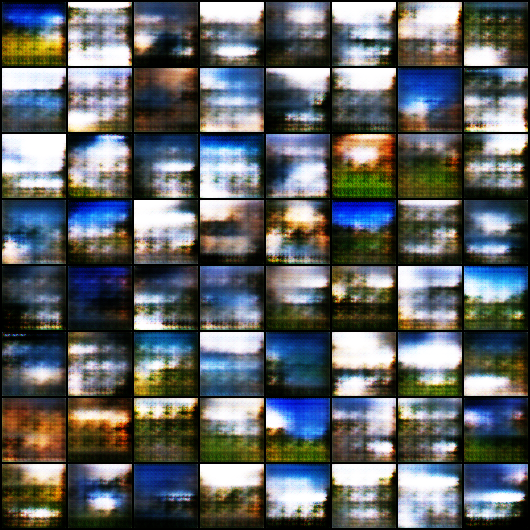

In [ ]:
# Images generated at epoch 1
Image('./generated/generated-images-0001.png')

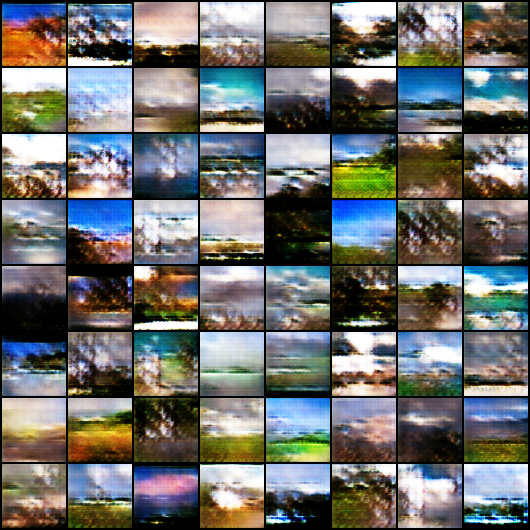

In [ ]:
# Images generated at epoch 25
Image('./generated/generated-images-0025.png')

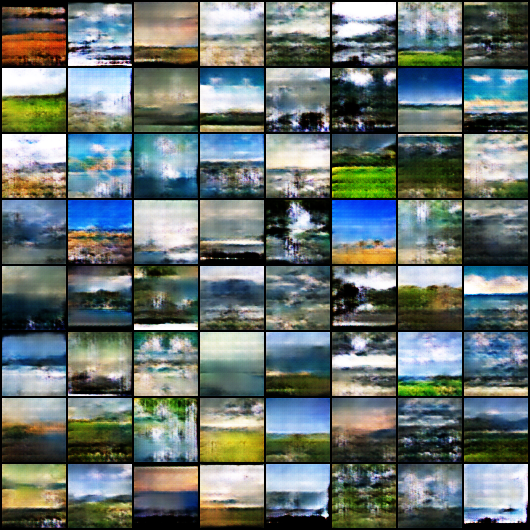

In [ ]:
# Images generated at epoch 50
Image('./generated/generated-images-0050.png')

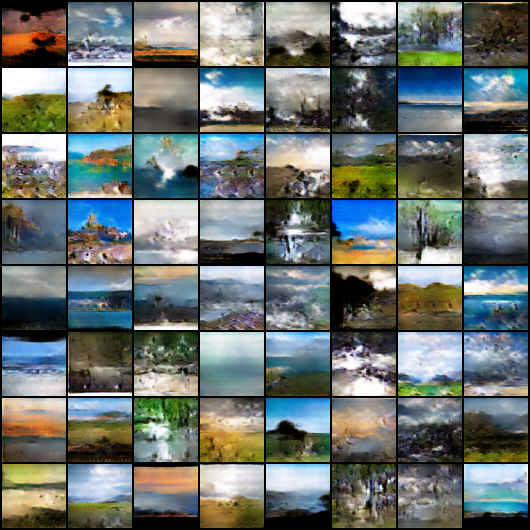

In [ ]:
# Images generated at epoch 75
Image('./generated/generated-images-0075.png')

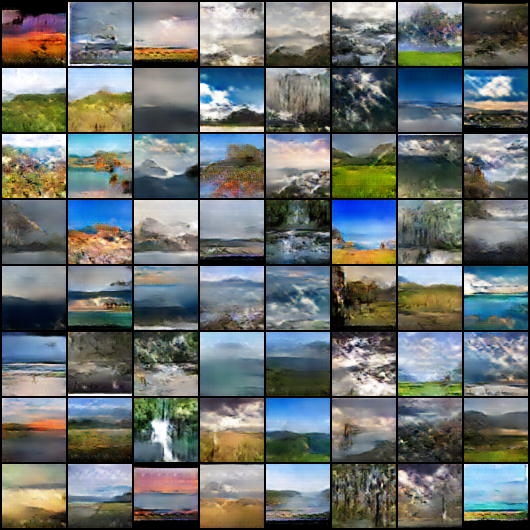

In [ ]:
# Images generated at epoch 100
Image('./generated/generated-images-0100.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV and create a video of the progression of the training.

In [ ]:
import cv2
import os

vid_fname = 'gans_training_2.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



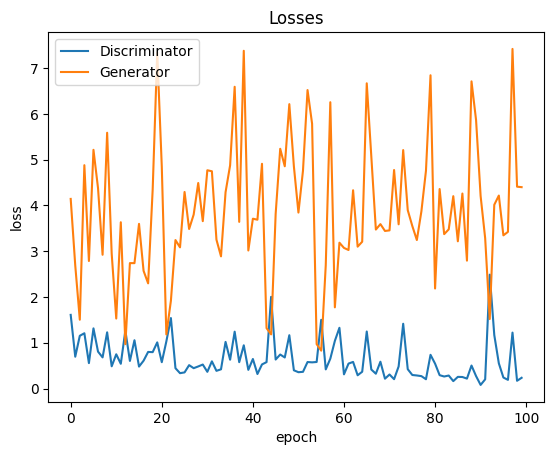

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

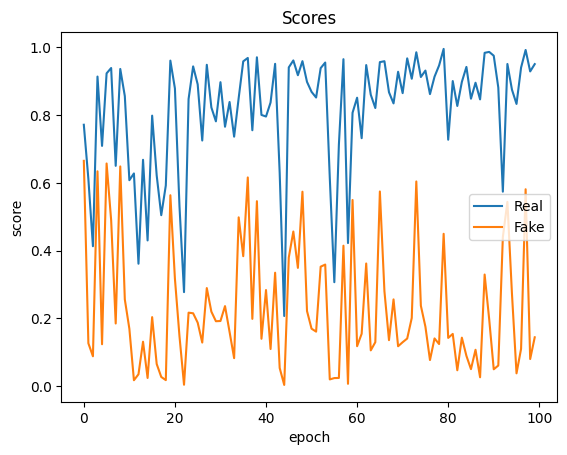

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Conclusion
The successful implementation of GANs in this project highlights the powerful capabilities of adversarial training for image generation tasks. By leveraging the competitive dynamics between the generator and discriminator, the project achieved the generation of realistic landscape images. This approach demonstrates the potential of GANs for various applications in generative modeling and creative content creation.

The repository serves as a comprehensive guide for understanding the intricacies of GANs, from data preparation to model architecture and training visualization. Future work can expand on this foundation by exploring different datasets, enhancing model architectures, and experimenting with advanced GAN techniques to further improve the quality and diversity of generated images.